In [1]:
import pandas as pd
import numpy as np

from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
test_data = pd.read_pickle('../data/test_data_not_filtered.pkl')
train_data = pd.read_pickle('../data/train_data_not_filtered.pkl')
feature_list = pd.read_pickle('../data_raw/features_RF_model.pkl')

In [3]:
classes = ['CEP',
           'DSCT',
           'E',
           'RRL',
           'LPV',
           'SLSN',
           'SNII',
           'SNIa',
           'SNIbc',
           'AGN',
           'Blazar',
           'CV/Nova',
           'QSO',
           'YSO']

outlier_index=13
outlier = classes[outlier_index]

In [4]:
train_data = train_data[(train_data['classALeRCE']!=outlier)]

print(np.unique(train_data.classALeRCE))

['AGN' 'Blazar' 'CEP' 'CV/Nova' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'QSO'
 'RRL' 'SLSN' 'SNII' 'SNIa' 'SNIbc']


## Train RF Model

In [5]:
train_labels = train_data[['classALeRCE', 'hierClass']]
train_data = train_data[feature_list] #using the same features and in the same order as the BHRF
train_data = train_data.fillna(-999)

In [6]:
train_data.head()

,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
40426,0.618536,0.417933,0.999711,1.000000,1.0,1.0,0.571429,0.107143,0.0,0.0,...,0.672857,0.938363,0.003,-0.136,13.041313,13.177313,13.849742,13.985742,0.099821,2.522379
51680,0.544903,0.342074,0.999999,0.999987,1.0,3.0,0.189189,0.444444,0.0,0.0,...,0.667857,0.995000,0.001,-0.117,12.456554,12.573554,12.586835,12.703835,0.015813,0.000000
60141,0.184424,0.184294,0.999998,0.999987,6.0,6.0,0.400000,0.290323,0.0,0.0,...,0.930000,0.993958,-0.003,-0.067,18.567266,18.634266,18.780239,18.847239,0.000000,0.499724
119855,0.641730,0.443864,0.999952,1.000000,1.0,1.0,0.357143,0.370370,0.0,0.0,...,0.880000,0.931631,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0.436855,0.000000
124921,0.056973,0.095254,1.000000,0.992339,1.0,1.0,0.227273,0.375000,0.0,0.0,...,0.760714,0.993750,-0.013,-999.000,-999.000000,14.529183,-999.000000,14.910563,0.000000,0.140446


In [7]:
hier_model = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
hier_model.fit(train_data, train_labels.hierClass)

BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               criterion='entropy', min_samples_leaf=1,
                               n_estimators=500, n_jobs=-1)

In [8]:
test = test_data.copy()
test_data = test_data[feature_list] #using the same features and in the same order as the BHRF
test_data = test_data.fillna(-999)

In [9]:
hier_pred = hier_model.predict(test_data)

In [10]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    #plt.close()

Normalized confusion matrix
[[99.  1.  0.]
 [ 7. 92.  0.]
 [ 1.  1. 99.]]


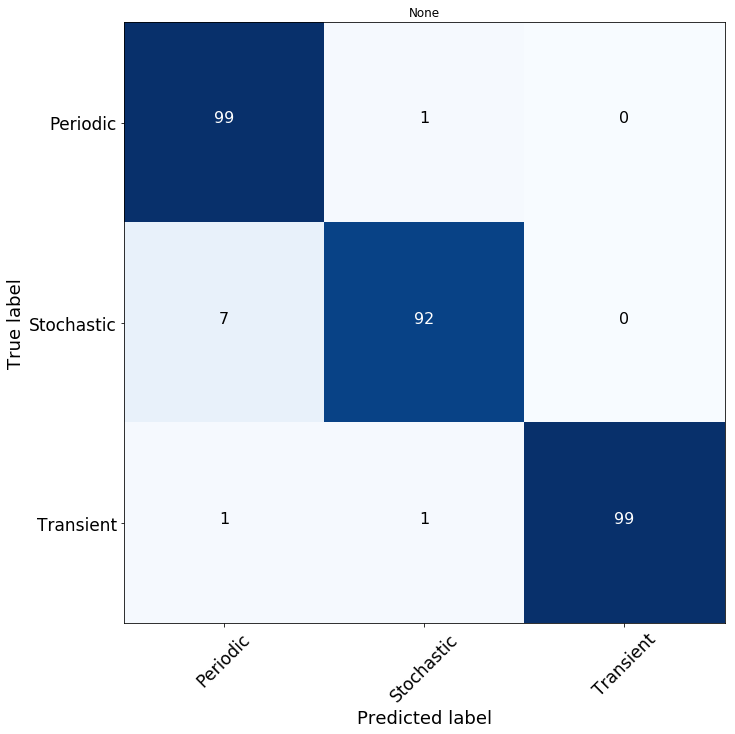

In [11]:
cm_ = confusion_matrix(list(test.hierClass), hier_pred)
plot_confusion_matrix(cm_, hier_model.classes_)

In [12]:
test = test.replace(-999, np.nan)
test['hierPred_without_{}'.format(outlier)] = hier_pred

test.head()

,oid,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,...,hierPred_without_LPV,hierPred_without_SLSN,hierPred_without_SNII,hierPred_without_SNIa,hierPred_without_SNIbc,hierPred_without_AGN,hierPred_without_Blazar,hierPred_without_CV/Nova,hierPred_without_QSO,hierPred_without_YSO
109168,ZTF18abmstko,0.296000,0.215788,1.0,1.000000,1.0,1.0,0.479167,0.210526,0.0,...,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic
4509,ZTF19aaaqluq,NaN,0.348402,NaN,0.984840,NaN,2.0,NaN,0.375000,NaN,...,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic
3253,ZTF19aaakgrl,0.310937,NaN,1.0,NaN,1.0,NaN,0.066667,NaN,0.0,...,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic
53589,ZTF18abgdhdy,0.553583,0.497798,1.0,0.994972,1.0,1.0,0.235294,0.272727,0.0,...,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic
79956,ZTF18aaabxhh,0.456318,0.339504,1.0,1.000000,1.0,1.0,0.419118,0.365217,0.0,...,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic,Periodic


In [13]:
test.to_pickle('../data/test_data_not_filtered.pkl')